In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage.segmentation import clear_border
from skimage import measure 
from skimage.measure import label, regionprops
from scipy import ndimage as ndi 
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom 
import plotly.graph_objects as go 
import plotly.io as pio
import plotly.offline as pyo
import os 
import cv2
from PIL import Image 

In [2]:
%config InlineBackend.figure_format = 'svg'
pio.renderers.default = 'svg'

In [3]:
adenocarcinoma_path_training = 'Data/Kaggle_Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/'
adenocarcinoma_path_test = 'Data/Kaggle_Data/test/adenocarcinoma/'

In [4]:
class NPmatrix_of_images():
    def __init__(self, path, format='.png', bitdepth=8, color='RGB') -> None:
        super().__init__()
        self.color = color
        self.bit = bitdepth
        self.maxvalue = 2**(self.bit) - 1
        self.path = path
        self.max_width, self.max_height = 0, 0
        self.image_filenames = [f for f in os.listdir(path) if f.endswith(format)]
        self.N = len(self.image_filenames)
        if self.color == 'CMYK': 
            self.extradim = 4 
        elif self.color == 'RGB':
            self.extradim = 3
        elif self.color == 'L':
            self.extradim = 0
        else: 
            raise NotImplementedError(color)
        
    def max_brightness(self): 
        return self.maxvalue
    
    def find_max_dims(self):
        for filename in self.image_filenames:
            img = Image.open(os.path.join(self.path, filename))
            w, h = img.size 
            if w > self.max_width: 
                self.max_width = w 
            if h > self.max_height:
                self.max_height = h 
        if self.extradim == 0:
            self.images = np.zeros((self.N, self.max_height, self.max_width))
        else: 
            self.images = np.zeros((self.N, self.max_height, self.max_width, self.extradim))

    def load_images_from_path(self):
        self.find_max_dims()
        for index, filename in enumerate(self.image_filenames):
            if self.color == 'RGB' or self.color == 'CMYK':
                img = Image.open(os.path.join(self.path, filename)).convert(self.color)
                img_arr = np.asarray(img)[:, :, :self.extradim]
            else:
                img = Image.open(os.path.join(self.path, filename)).convert(self.color)
                img_arr = np.asarray(img)
            self.images[index, :img_arr.shape[0], :img_arr.shape[1]] = img_arr
        return self.images

I had no access to the original dataset that was already prepackaged into a numpy array of 263 images of resolution 512x512, so I had to create my own class to deal with a PNG dataset I downloaded from Kaggle, which had all sorts of issues, included unmatching resolutions that I had to pad with pixel of value 0 to the max res found, an unnecessary alpha channel that I suppressed, etc. Hopefully this will give me something to work with though. 

In [5]:
img = NPmatrix_of_images(adenocarcinoma_path_training, color='L').load_images_from_path()
img.shape

(195, 874, 1200)

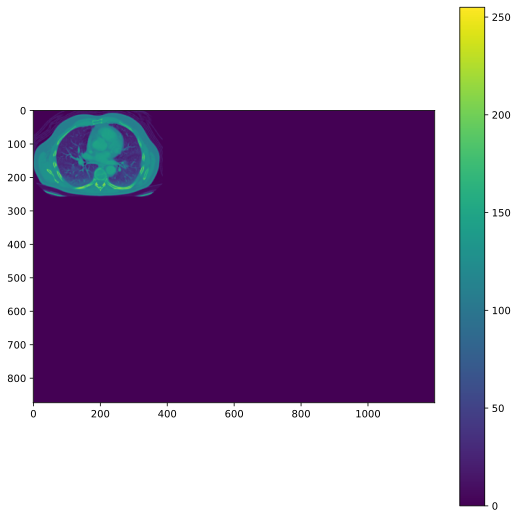

In [6]:
plt.figure(figsize=(9, 9))
plt.imshow(img[20])
plt.colorbar()
plt.show()

The dataset I downloaded from Kaggle sucks, I doubt the images could be useful for stacking since their resolutions don't match and there's no alignment between them. Anyway, even if this is ugly, that should work for image segmentation, I guess.

# Image values

The pixel values of each image is expressed in **Hounsfield Units** 

$$ HU(x, y) \equiv 1000 \cdot \displaystyle \frac{\mu(x, y) - \mu_{water}}{\mu_{water} - \mu_{air}} $$

where $\mu(x, y)$ is the linear attenuation coefficient of the material at position $(x, y)$, $\mu_{water}$ is the linear attenuation coefficient of water and $\mu_{air}$ is the linear attenuation coefficient of air.

This linear attenuation coefficient is defined on how the intensity of a photon beam decays as it passes a distance $x$ through a material 

$$ I = I_0 \cdot e^{-\mu \cdot x} $$

where $\mu$ depends on the energy of the incident photon beam, which for CT scans is $\approx 100 \ keV$.


| Substance | HU Value |
| --- | ---: |
| Air | -1000 |
| Fat | -120 to -70 |
| Water | 0 |
| Blood | 30 to 45 |
| Muscle | 10 to 40 |
| Bone | 1000 to 3000 |